<a href="https://colab.research.google.com/github/EStalei/TCC/blob/main/_final_tcc_plataforma_de_testes_eike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
!pip install gower

In [ ]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import seaborn as sns
import prince
import gower
warnings.filterwarnings("ignore")
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score   #Para a validação (silhueta)
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv("NCT02646943 (2).csv", delimiter=';')

In [ ]:
df.replace(99, np.nan, inplace=True)

null_counts = df.isnull().sum()

total_rows = len(df)

null_percentage = (null_counts / total_rows) * 100

#print(null_percentage)

columns_to_keep = null_percentage[null_percentage < 20].index

df_filtered = df[columns_to_keep]

#print(df_filtered)

In [ ]:
imputador = SimpleImputer(strategy='median')
df_imputed_array = imputador.fit_transform(df_filtered)
df_imputed = pd.DataFrame(df_imputed_array, columns=df_filtered.columns)


In [ ]:
# Variáveis com mais de 2 categorias e menos de 20 → geralmente categóricas
cat_multiclass = [
    c for c in df_imputed.columns
    if df_imputed[c].nunique() > 2 and df_imputed[c].nunique() < 20
]

print("Categóricas detectadas:", cat_multiclass)

Categóricas detectadas: ['FQI010cor', 'FQI013est_civil_agrup', 'FQV001hab_cigarro', 'FQV003qto_bebe', 'FQC067percepcao_saude', 'FQT001rochagan', 'FK201count_of_major_changes', 'FK202ecg_result', 'FO012ECGtipicoProBNPidade_D', 'FO001classefuncional']


In [ ]:
df_dummies = pd.get_dummies(df_imputed[cat_multiclass], drop_first=False)
df_sem_cat = df_imputed.drop(columns=cat_multiclass)

df_dummied = pd.concat([df_sem_cat, df_dummies], axis=1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalizado = pd.DataFrame(scaler.fit_transform(df_dummied), columns=df_dummied.columns)

#scaler = MinMaxScaler(feature_range=(0, 1))
#df_normalizado = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

#df_normalizado.columns

#print(df_normalizado)

In [ ]:
matriz_correlacao = df_normalizado.corr()

#plt.figure(figsize=(84, 84))
#sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title('Mapa de Calor da Correlação de Variáveis')
#plt.show()

In [ ]:
matriz_correlacao = df_normalizado.corr()

# Transformar a matriz em formato longo (pares de variáveis)
corr_pairs = matriz_correlacao.unstack()

# Remover autocorrelações (variável com ela mesma)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Ordenar por valor absoluto (decrescente)
corr_pairs = corr_pairs.abs().sort_values(ascending=False)

# Remover duplicatas (A-B e B-A)
corr_pairs = corr_pairs[~corr_pairs.index.duplicated()]

# Mostrar as 10 maiores correlações
#print("\n🔝 Top 10 correlações mais fortes:")
print(corr_pairs.head(50).to_string())

FK009sinus_average_rr           FK007heart_rate                   0.924072
FK007heart_rate                 FK009sinus_average_rr             0.924072
FO015class_cardio1_D            FK202ecg_result                   0.915386
FK202ecg_result                 FO015class_cardio1_D              0.915386
FO012ECGtipicoProBNPidade_D     FO015class_cardio1_D              0.855858
FO015class_cardio1_D            FO012ECGtipicoProBNPidade_D       0.855858
FQC014hipertensao               FQC016nenh_comorbidade            0.849911
FQC016nenh_comorbidade          FQC014hipertensao                 0.849911
FK020qtc                        FK018overall_qt_intervals         0.846593
FK018overall_qt_intervals       FK020qtc                          0.846593
FK201count_of_major_changes     FO015class_cardio1_D              0.802012
FO015class_cardio1_D            FK201count_of_major_changes       0.802012
FK202ecg_result                 FO012ECGtipicoProBNPidade_D       0.789933
FO012ECGtipicoProBNPidade

sociais: sexo, idade, cor, renda, alfabetização,

hábitos de vida: Uso de álcool, tabaco e atividade física

Clinicas: Classe funcional, uso de marcapasso, uso rochagan, infarto (iam), hipertensão, resultado do eletrocardiograma(ECG result), bnp.

In [ ]:
#dados = df_normalizado.drop(columns=['FK009sinus_average_rr', 'FO015class_cardio1_D', 'FK020qtc', 'FQC016nenh_comorbidade', 'FO012ECGtipicoProBNPidade_D', 'FK201count_of_major_changes', 'FK013std_dev_norm_rr_intervals','FQC060marcapasso_permanente', 'FK172major_q_prolong', 'FQC062acordar_noite', 'FK007heart_rate'])

v_sociais = ['SE004sexo',
              'SE011idade_o1',
              'FQI010cor',
              'FQI017renda_percapta',
              'FQI011alfabetizado',]
v_habitos = ['FQV005consumo_alcool',
              'FQV001hab_cigarro',
              'FQF001ativ_fisica',]
v_clinicas = ['FO001classefuncional',
              'FQC060marcapasso_permanente',
              'FQT001rochagan',
              'FQC013iam',
              'FQC014hipertensao',
              'FK202ecg_result',
              'FO003probnp_cat_D',]

variaveis = ['FK007heart_rate','FK012heart_rate_variability','FK018overall_qt_intervals','FK026overall_qrs_duration','FO003probnp_cat_D']

dados = df_normalizado[variaveis]


# **Usando Gower**




Algoritmo: K-Means - Usando matriz de Grower (não recomendado)
Silhouette Score: 0.7992


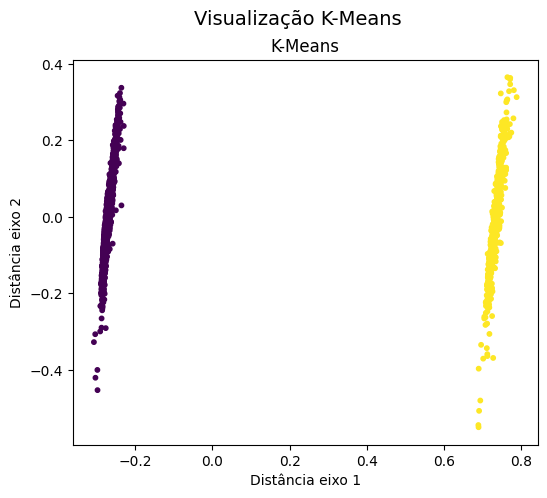

In [ ]:
#gower_dist = gower.gower_matrix(dados)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(dados)

# Apenas um algoritmo
algorithms = [
    ('K-Means', KMeans(n_clusters=2, random_state=1, n_init='auto')),
]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fig.suptitle(f'Visualização K-Means', fontsize=14)

for i, (name, algo) in enumerate(algorithms):
    try:
        labels = algo.fit_predict(dados)

        print(f"\nAlgoritmo: {name} - Usando matriz de Grower (não recomendado)")

        # plot usando duas colunas arbitrárias da matriz de distância
        ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=10)
        ax.set_title(f'{name}')
        ax.set_xlabel('Distância eixo 1')
        ax.set_ylabel('Distância eixo 2')

        # Silhouette (também não recomendado neste caso)
        n_unique_labels = len(np.unique(labels))
        n_samples = len(dados)
        if n_unique_labels > 1 and n_unique_labels < n_samples:
            score = silhouette_score(dados, labels)
            print(f"Silhouette Score: {score:.4f}")
        else:
            print(f"Não é possível calcular o Silhouette Score ({n_unique_labels} labels únicos).")

    except Exception as e:
        print(f"Erro com o algoritmo {name}: {e}")



In [ ]:
print(labels)

[1 0 0 ... 0 0 0]


# **Melhor numero de grupos**

In [ ]:
import os

os.makedirs("/mnt/data", exist_ok=True)

In [ ]:
# Requisitos: pandas, numpy, matplotlib, seaborn
# Instalar se necessário:
# pip install pandas numpy matplotlib seaborn

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import textwrap

# --------------------------------------------------
# === CONFIGURAÇÃO DOS SEUS DADOS ===
# --------------------------------------------------

dados = df_dummied[v_clinicas]

df = dados.copy()     # sua base
df["grupo"] = labels           # vetor de clusters

group_col = "grupo"

# --------------------------------------------------
# === DETECTAR AUTOMATICAMENTE CONTÍNUAS E CATEGÓRICAS ===
# --------------------------------------------------

nunique = df.nunique(dropna=False)

# critérios (ajuste se quiser)
max_cat_levels = 20    # até 20 categorias = categórica
min_cont_levels = 21   # 21 ou mais valores únicos = contínua

cat_cols = [c for c in df.columns if (nunique[c] >= 2 and nunique[c] <= max_cat_levels) and c != group_col]
num_cols = [c for c in df.columns if nunique[c] >= min_cont_levels and c != group_col]

# binárias (tratadas como categóricas)
bin_cols = [c for c in df.columns if nunique[c] == 2 and c != group_col]

# assegurar numéricas realmente numéricas
num_cols = [c for c in num_cols if pd.api.types.is_numeric_dtype(df[c])]

# garantir categóricas extras
other_cols = [c for c in df.columns if c not in num_cols + cat_cols + bin_cols + [group_col]]
cat_cols += other_cols

# --------------------------------------------------
# === FUNÇÃO: SALVAR PÁGINAS DE TEXTO NO PDF ===
# --------------------------------------------------

def save_text_page(pp, title, lines, fontsize=10, wrap_width=90):
    fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4
    ax.axis('off')
    y = 0.95
    ax.text(0.01, y, title, fontsize=14, weight='bold', transform=ax.transAxes)
    y -= 0.04
    for line in lines:
        wrapped = textwrap.wrap(str(line), wrap_width)
        for w in wrapped:
            ax.text(0.01, y, w, fontsize=fontsize, transform=ax.transAxes)
            y -= 0.03
            if y < 0.03:
                pp.savefig(fig)
                plt.close(fig)
                fig, ax = plt.subplots(figsize=(8.27, 11.69))
                ax.axis('off')
                y = 0.95
    pp.savefig(fig)
    plt.close(fig)

# --------------------------------------------------
# === INICIAR RELATÓRIO PDF ===
# --------------------------------------------------

output_pdf = "/mnt/data/exploratory_report_clinicas.pdf"

with PdfPages(output_pdf) as pp:

    # ---------------------------
    # CAPA
    # ---------------------------
    title_lines = [
        "Relatório de Análise Exploratória por Grupos",
        "",
        f"Base usada: Variaveis Clinicas",
        f"Nº de linhas: {df.shape[0]}",
        f"Nº de colunas: {df.shape[1]}",
        f"Vetor de grupos: labels → adicionado como coluna '{group_col}'",
        "",
        "Detecção automática de variáveis:",
        f"- Contínuas: nunique >= {min_cont_levels}",
        f"- Categóricas: 2 <= nunique <= {max_cat_levels}",
    ]
    save_text_page(pp, "Capa do Relatório", title_lines)

    # ---------------------------
    # LISTA DE VARIÁVEIS
    # ---------------------------
    cols_summary = [
        f"Numéricas contínuas ({len(num_cols)}): {num_cols}",
        f"Categóricas ({len(cat_cols)}): {cat_cols}",
        f"Binárias ({len(bin_cols)}): {bin_cols}"
    ]
    save_text_page(pp, "Classificação das Variáveis", cols_summary)

    # ---------------------------
    # ESTATÍSTICAS POR GRUPO (CONTÍNUAS)
    # ---------------------------
    if len(num_cols) > 0:
        for col in num_cols:
            try:
                stats = df.groupby(group_col)[col].agg(['count','mean','median','std','min','max']).round(4)

                # tabela de estatísticas
                fig, ax = plt.subplots(figsize=(8.27, 11.69))
                ax.axis('off')
                ax.set_title(f"Estatísticas por Grupo — {col}", fontsize=14)
                table = ax.table(
                    cellText=stats.reset_index().values,
                    colLabels=list(stats.reset_index().columns),
                    loc='center',
                    cellLoc='center'
                )
                table.auto_set_font_size(False)
                table.set_fontsize(9)
                table.scale(1, 1.2)
                pp.savefig(fig)
                plt.close(fig)

                # boxplot
                plt.figure(figsize=(8,5))
                sns.boxplot(data=df, x=group_col, y=col)
                plt.title(f"Boxplot — {col} por Grupo")
                plt.tight_layout()
                pp.savefig()
                plt.close()
            except Exception as e:
                save_text_page(pp, f"Erro ao processar {col}", [str(e)])

    else:
        save_text_page(pp, "Nenhuma variável contínua detectada", ["Nenhuma contínua encontrada."])

    # ---------------------------
    # FREQUÊNCIAS (CATEGÓRICAS)
    # ---------------------------
    all_cat = cat_cols + bin_cols

    if len(all_cat) > 0:
        for col in all_cat:
            try:
                freq_abs = df.groupby(group_col)[col].value_counts().unstack(fill_value=0)
                freq_pct = df.groupby(group_col)[col].value_counts(normalize=True).unstack(fill_value=0).round(4)

                # tabela de frequência absoluta
                fig, ax = plt.subplots(figsize=(8.27, 11.69))
                ax.axis('off')
                ax.set_title(f"Frequência Absoluta — {col}", fontsize=14)
                tbl = ax.table(cellText=freq_abs.reset_index().values,
                               colLabels=list(freq_abs.reset_index().columns),
                               loc='center')
                tbl.auto_set_font_size(False)
                tbl.set_fontsize(9)
                tbl.scale(1, 1.2)
                pp.savefig(fig)
                plt.close(fig)

                # tabela de frequência relativa
                fig, ax = plt.subplots(figsize=(8.27, 11.69))
                ax.axis('off')
                ax.set_title(f"Frequência Relativa — {col}", fontsize=14)
                tbl2 = ax.table(cellText=freq_pct.reset_index().values,
                                colLabels=list(freq_pct.reset_index().columns),
                                loc='center')
                tbl2.auto_set_font_size(False)
                tbl2.set_fontsize(9)
                tbl2.scale(1, 1.2)
                pp.savefig(fig)
                plt.close(fig)

                # gráfico de barras
                plt.figure(figsize=(8,5))
                freq_pct.plot(kind='bar')
                plt.title(f"Distribuição de {col} por Grupo")
                plt.ylabel("Proporção")
                plt.xlabel("Grupo")
                plt.tight_layout()
                pp.savefig()
                plt.close()
            except Exception as e:
                save_text_page(pp, f"Erro ao processar {col}", [str(e)])

    else:
        save_text_page(pp, "Nenhuma variável categórica detectada", ["Nenhuma variável com <=20 categorias encontrada."])

    # ---------------------------
    # FINAL
    # ---------------------------
    final_lines = [
        "Fim do relatório.",
        "",
        f"Arquivo gerado: {output_pdf}"
    ]
    save_text_page(pp, "Fim do Relatório", final_lines)

print("RELATÓRIO GERADO EM:", output_pdf)


RELATÓRIO GERADO EM: /mnt/data/exploratory_report_clinicas.pdf


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>